In [2]:
import numpy as np
from larch import Group
from glob import glob
import re
import matplotlib.pyplot as plt
from os import path
import os
!git clone https://github.com/kaifengZheng/zanes.git
from zanes.zanes import data_analysis as da
from scipy.interpolate import interp1d
import pandas as pd


fatal: destination path 'zanes' already exists and is not an empty directory.


# data analysis for non-modulation measurements

In [3]:
def data_collect(datadict,tag):
    E_achi,mu_achi,mu_achi_get,E_achi=[],[],[],[]
    E_max,E_min=[],[]
    for file  in datadict[tag]:
        E_get,mu_get=read_data(file)
        E_achi.append(E_get)
        mu_achi.append(mu_get)
        E_max.append(E_get[-1])
        E_min.append(E_get[0])
    E_mesh=np.linspace(np.max(E_min),np.min(E_max),500)
    for i in range(len(mu_achi)):
        mu_achi_get.append(interp1d(E_achi[i],mu_achi[i])(E_mesh))
    return E_mesh,np.array(mu_achi_get)

def get_ave(E,mu):
    return E,mu.mean(axis=0)
def plot_data(E,mu,tag):
    for i in range(len(mu)):
        if i==0:
            plt.plot(E,mu[i],label=tag,alpha=0.3)
        else:
            plt.plot(E,mu[i],alpha=0.3)
    plt.plot(E,mu.mean(axis=0),label='mean',color='red')
    plt.legend(frameon=False)
    
def get_datadict(filenames):
    name_dict=dict()
    for name in filenames:
        basednames=path.basename(name)
        match_name=re.match('(^.+)\s+',basednames)[0]
        if match_name not in name_dict.keys():
            name_dict[match_name]=[]
        if match_name in name:
            name_dict[match_name].append(name)
    return name_dict
def read_data(filename):
    data=np.loadtxt(filename,comments='#')
    return data[:,0],data[:,4]/data[:,1] #flou data

def get_larch_groups(datadict,tag):
    E_achi,mu_achi=data_collect(datadict,tag)
    
    groups=[]
    for i in range(len(mu_achi)):
        groups.append(Group(energy=E_achi,mu=mu_achi[i],label=path.basename(datadict[tag][i])))
    return groups
              

In [4]:
filenames=sorted(glob("/nsls2/data/qas-new/legacy/processed/2024/2/315439/*.dat"), key=os.path.getmtime,reverse=True)

In [5]:
name_dict=get_datadict(filenames)

In [6]:
keys=list(name_dict.keys())
print("show key_num and corresponding measurement")
for i in range(len(keys)):
    print(f"{i}\t{keys[i]}")

show key_num and corresponding measurement
0	SS24_Pd20_S1_Final_RT_at_O2 
1	DC23_Pd20_S1 in O2_400C_to_RT 
2	DC22_Pd20_S1 in O2 afterlast ME_at_400C 
3	ME21_Pd20_S1_afterH2_pretreatmetn_15sCH4_15sO2_60cycles_at_450C_ 
4	ME20_Pd20_S1_afterH2_pretreatmetn_15sH2_15sO2_60cycles_at_450C_ 
5	SS19_Pd20_S1_H2_Pretreatment _450C_InH2_N2 
6	ME18_Pd20_S1_at440C_15sO2_15sH2_15sCH4_60cycles 
7	ME17_Pd20_S1_at440C_15sO2_15sCH4_60cycles 
8	ME15_Pd20_S1_at440C_15sO2_15sH2_60 cycles 
9	SS15_Pd20_S1_at440C_inO2_Air 
10	DH14_Pd20_S1_During_Heating_RT_to_500C_inO2_Air 
11	SS13_Pd20_S1_50C_inO2_Air 
12	DC12_Pd20_S1_400C_to_50C_inO2_Air 
13	DH11_Pd20_S1_During_Heating_400C_to_500C_inO2_Air 
14	SS11_PostMES_CH4_O2_at_400C_inO2_Air 
15	ME10_15sCH4_15sO2_60cycles_at_400C 
16	ME09_15sH2_15sO2_60cycles_at_400C 
17	SS08_2nd_O2_Pretreatment_at_400C_inO2_Air 
18	test 
19	SS07_Pd20_S1_PostMES_at_RT 
20	ME06_Pd20_S1_at_200C_5sO2_5sCH4_60cycles 
21	ME05_Pd20_S1_at_200C_30sO2_30sCH4_60cycles 
22	SS04_Pd20_S1_at_200C_in

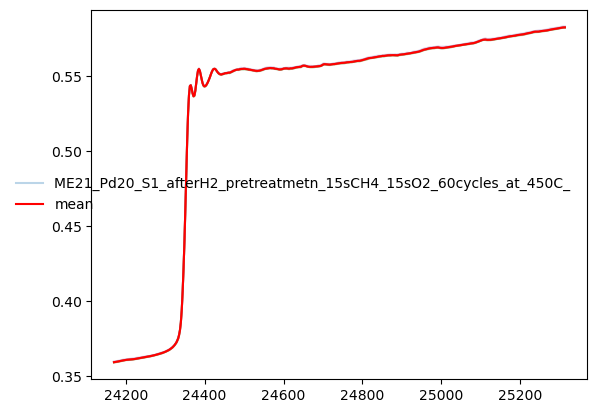

In [7]:
key_num=3
E,mu=data_collect(name_dict,keys[key_num])
plot_data(E,mu,keys[key_num])
E_ave,mu_ave=get_ave(E,mu)

In [8]:
groups=get_larch_groups(name_dict,tag=keys[key_num])
group_ave=Group(energy=E_ave,mu=mu_ave,label=keys[key_num])

In [9]:
for i in range(len(groups)):
    da.data_processing(groups[i],e0=None, pre_start=-200,pre_end=-60,post_start=80,post_end=950,kweight=2,rbkg=1,
                  plot=False,kwin='hanning',dk=2,krange=[2,8])


E0=24350.17348929459


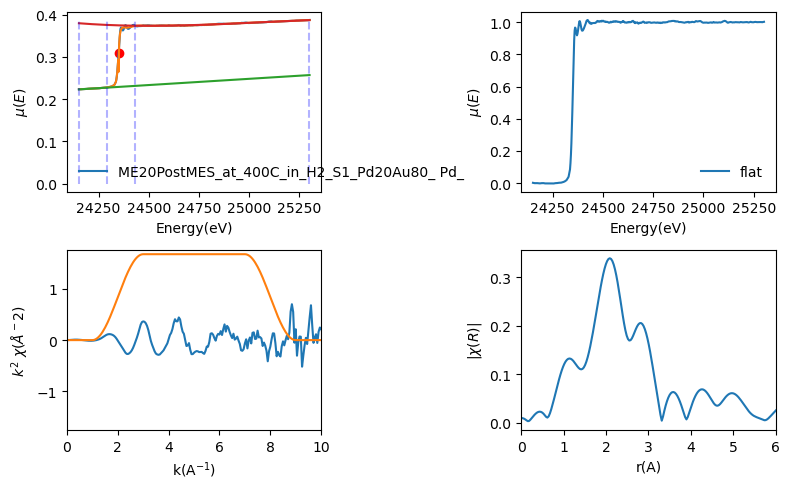

In [10]:
da.data_processing(group_ave,e0=None, pre_start=-200,pre_end=-60,post_start=80,post_end=950,kweight=2,rbkg=1,
                  plot=True,kwin='hanning',dk=2,krange=[2,8])

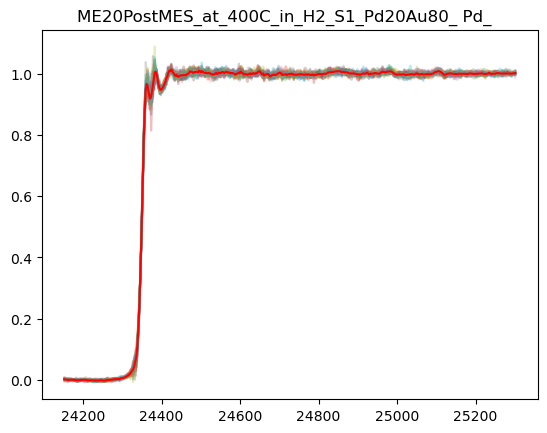

In [11]:
plt.figure()
for i in range(len(groups)):
    plt.plot(groups[i].energy,groups[i].flat,alpha=0.3)
plt.title(keys[key_num])
plt.plot(group_ave.energy,group_ave.flat,color='red')

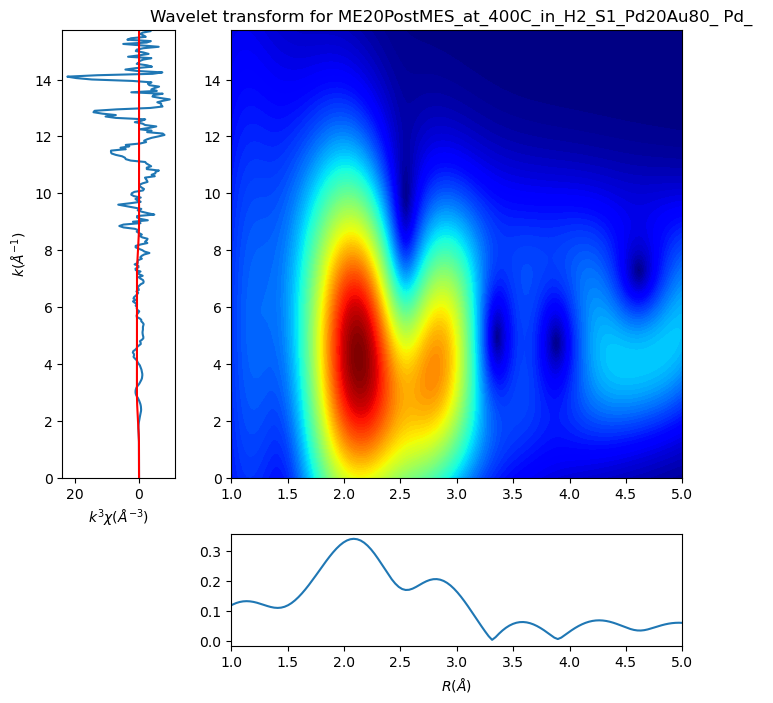

In [12]:
da.wavelet_transform(group_ave, kweight=2, plot=True) #wavelet transform

# data analysis for modulation measurements

In [10]:
from scipy.interpolate import interp1d
def read_data(filename):
    data=np.loadtxt(filename,comments='#')
    return data[:,0],data[:,4]/data[:,1] #flou data
def read_data_ref(filename):
    data=np.loadtxt(filename,comments='#')
    return data[:,0],-np.log(data[:,3]/data[:,1]) #flou data

def data_dict_modu(filenames):
    name_dict=dict()
    for name in filenames:
        basedname=path.basename(name)
        # print(basednames)
        match_name=basedname.split('.')[0].split(' ')[0]
        traj_num=int(basedname.split('_')[-2].split(' ')[1])
        # print(f"{name} {cycle_num}")
        scan_num=int(basedname.split('_')[-1].split('.')[0])
        up_down=basedname.split('_')[2]
        if match_name not in name_dict.keys():
            name_dict[match_name]=[{'full_path':name,
                                   "tag":match_name,
                                   "traj_num":traj_num,
                                   "scan_num":scan_num,
                                   "up_down":up_down}]
        else:
            name_dict[match_name].append({'full_path':name,
                                   "tag":match_name,
                                   "traj_num":traj_num,
                                   "scan_num":scan_num,
                                   "up_down":up_down})
    return name_dict
def data_collect(filelist):
    E_achi,mu_achi=[],[]
    for file  in filelist:
        E_get,mu_get=read_data(file)
        E_achi.append(E_get)
        mu_achi.append(mu_get)
    return E_achi,mu_achi
def data_collect_ref(filelist):
    E_achi,mu_achi=[],[]
    for file  in filelist:
        E_get,mu_get=read_data_ref(file)
        E_achi.append(E_get)
        mu_achi.append(mu_get)
    return E_achi,mu_achi
    
def name_collect(dict_modu,tag,mode='first',traj_num=2,total_scan=100,scans_per_switch=10): #'dn'
    names=[]
    datapoints=dict_modu[tag]
    datapoints=[datapoints[i] for i in range(len(datapoints)) if datapoints[i]['traj_num']==traj_num]
    datapoints=sorted(datapoints, key=lambda x: x['scan_num'])
    scan_nums=[datapoints[i]['scan_num'] for i in range(len(datapoints))]
    # print(scan_nums)
    switch=total_scan//scans_per_switch
    # first_batch=[i*10+j for i in range(period) for j in range(i*10,(i+1)*10) ]
    first=[]
    second=[]
    first_record_scan=[]
    second_record_scan=[]
    for i in range(switch):
        for j in range(len(datapoints)):
            if datapoints[j]['scan_num'] in range(i*switch+1,i*switch+switch) and i%2==0 and datapoints[j]['full_path'] not in first:
                first.append(datapoints[j]['full_path'])
                first_record_scan.append(datapoints[j]['scan_num'])
            if datapoints[j]['scan_num'] in range(i*switch,i*switch+switch+1) and i%2==1 and datapoints[j]['full_path'] not in second and datapoints[j]['full_path'] not in first:
                second.append(datapoints[j]['full_path'])
                second_record_scan.append(datapoints[j]['scan_num'])
    if mode=='first':
        # if data['scan_num']==
        names=first
        print(f"first={first_record_scan}")
    if mode=='second':
        names=second
        print(f"second={second_record_scan}")
    return names
def name_collect_alltraj(dict_modu,tag,mode='first',total_scan=100):
    datapoints=dict_modu[tag]
    traj_num=np.unique(np.array([int(datapoints[i]['traj_num']) for i in range(len(datapoints))]))
    names=[]
    for i in range(len(traj_num)):
        names_col=name_collect(dict_modu,tag,mode=mode,traj_num=traj_num[i],total_scan=total_scan)
    names.extend(names_col)
    return names
def name_collect3(dict_modu,tag,mode='first',traj_num=2,total_scan=36,scans_per_period=10): #'dn'
    names=[]
    datapoints=dict_modu[tag]
    period=np.int32(np.floor(total_scan/scans_per_period))
    # first_batch=[i*10+j for i in range(period) for j in range(i*10,(i+1)*10) ]
    first=[]
    second=[]
    for i in range(period):
        for j in range(total_scan):
            if j >=i*period:
                if j in range(i*period,i*period+period//3):
                    first.append(datapoints[i]['full_path'])
                elif j in range(i*period+period//3,i*period+period*2//3):
                    second.append(datapoints[i]['full_path'])
                else:
                    third.append(datapoints[i]['full_path'])
            if j==(i+1)*period:
                break
    if mode=='first':
        # if data['scan_num']==
        names=first
    if mode=='second':
        names=second
    if mode=='third':
        names=third
    return names
def plot_data(E,mu,tag,color='r',alpha=0.3):
    for i in range(len(mu)):
        if i==0:
            plt.plot(E[i],mu[i],label=tag,alpha=alpha)
        else:
            plt.plot(E[i],mu[i],alpha=alpha)
    plt.plot(E.mean(axis=0),mu.mean(axis=0),label='mean',color=color)
    plt.legend(frameon=False)
def get_larch_groups(filenames):
    E_achi,mu_achi=data_collect(filenames)
    groups=[]
    for i in range(len(E)):
        groups.append(Group(energy=E_achi[i],mu=mu_achi[i],label=path.basename(filenames[i])))
    return groups
def get_ave(E,mu):
    return E.mean(axis=0),mu.mean(axis=0)
def get_ave_cycle(data_dict,key_num,mode='first',data_tag='iff',traj_num=2,total_scan=36,scans_per_switch=10):
    """
    data_dict: return value of function data_dict_modu(filenames): details of file information
    key_num: The specific measurement index. 
    """
    traj=[]
    e_all=[]
    mu_all=[]
    for k in data_dict[key[key_num]]:
        if k['traj_num'] not in traj:
            traj.append(k['traj_num'])
    print(f"num of trajactories:{traj}")
    for t in traj:
        data=name_collect(data_dict,key[key_num],mode=mode,traj_num=t,total_scan=total_scan,scans_per_switch=scans_per_switch)
        if data_tag=='iff':
            e1,mu1=data_collect(data)
        if data_tag=='ref':
            e1,mu1=data_collect_ref(data)
        for i in range(len(e1)):
            e_all.append(np.array(e1[i]))
            mu_all.append(np.array(mu1[i]))
    # print(e_all)
    e,mu=interp_data(e_all,mu_all)
    
    e_all=np.array(e)
    mu_all=np.array(mu).mean(axis=0)
    # print(e_all.mean(axis=0))
    return e_all,mu_all

def get_ave_cycle3(data_dict,key_num,mode='first',traj_num=2,total_scan=10):
    """
       This script works for the modulation between O, H2 and CH4
    """
    traj=[]
    e_all=[]
    mu_all=[]
    for k in dic[key[key_num]]:
        if k['traj_num'] not in traj:
            cycles.append(k['traj_num'])
    print(f"traj:{traj}")
    for t in traj:
        data=name_collect3(data_dict,key[key_num],mode=mode,traj_num=t,total_scan=total_scan,scans_per_period=scans_per_period)
        e1,mu1=data_collect(data)
        for i in range(len(e1)):
            e_all.append(np.array(e1[i]))
            mu_all.append(np.array(mu1[i]))
    # print(e_all)
    e_all=np.array(e_all).mean(axis=0)
    mu_all=np.array(mu_all).mean(axis=0)
    # print(e_all.mean(axis=0))
    return e_all,mu_all
def interp_data(e_collect,mu_collect):
    e_max=min([e_collect[i][-1] for i in range(len(e_collect))])
    e_min=max([e_collect[i][0] for i in range(len(e_collect))])
    e_len=max([len(e_collect[i]) for i in range(len(e_collect))])
    e=np.linspace(e_min,e_max,500)
    mu=[interp1d(e_collect[i],mu_collect[i])(e) for i in range(len(e_collect))]
    return e,mu
    
    
    

In [11]:
%matplotlib widget

In [12]:
# def read_data(filename):
#     data=np.loadtxt(filename,comments='#')
#     return data[:,0],data[:,4]/data[:,1] #flou data
# # read_data
# read_data(filenames[0])[0]
# def data_collect(filelist):
#     E_achi,mu_achi=[],[]
#     for file  in filelist:
#         E_get,mu_get=read_data(file)
#         E_achi.append(E_get)
#         mu_achi.append(mu_get)
# data_collect(filenames)

In [13]:
filenames=sorted(glob("/nsls2/data/qas-new/legacy/processed/2024/2/315439/Oscillatory_processed/ME*.dat"), key=os.path.getmtime,reverse=True)
data_dict=data_dict_modu(filenames)
key=list(data_dict.keys())
print("show key_num and corresponding measurement:")
for i in range(len(key)):
    print(f"{i}\t{key[i]}")

show key_num and corresponding measurement:
0	ME10_1st_dn_ME10_15sCH4_15sO2_60cycles_at_400C
1	ME10_1st_up_ME10_15sCH4_15sO2_60cycles_at_400C
2	ME05_1st_dn_ME05_Pd20_S1_at_200C_30sO2_30sCH4_60cycles
3	ME05_1st_up_ME05_Pd20_S1_at_200C_30sO2_30sCH4_60cycles
4	ME06_1st_dn_ME06_Pd20_S1_at_200C_5sO2_5sCH4_60cycles
5	ME06_1st_up_ME06_Pd20_S1_at_200C_5sO2_5sCH4_60cycles


In [14]:
key_num=0
traj_num=1
total_scan=100
scans_per_switch=20
table=pd.DataFrame(data_dict[key[key_num]])
print(f"total {key[key_num]} spectra: {len(table)}")
table[table['traj_num']==traj_num].head()
# table: row number is the total scan

total ME10_1st_dn_ME10_15sCH4_15sO2_60cycles_at_400C spectra: 250


,full_path,tag,traj_num,scan_num,up_down
200,/nsls2/data/qas-new/legacy/processed/2024/2/31...,ME10_1st_dn_ME10_15sCH4_15sO2_60cycles_at_400C,1,100,dn
201,/nsls2/data/qas-new/legacy/processed/2024/2/31...,ME10_1st_dn_ME10_15sCH4_15sO2_60cycles_at_400C,1,98,dn
202,/nsls2/data/qas-new/legacy/processed/2024/2/31...,ME10_1st_dn_ME10_15sCH4_15sO2_60cycles_at_400C,1,96,dn
203,/nsls2/data/qas-new/legacy/processed/2024/2/31...,ME10_1st_dn_ME10_15sCH4_15sO2_60cycles_at_400C,1,94,dn
204,/nsls2/data/qas-new/legacy/processed/2024/2/31...,ME10_1st_dn_ME10_15sCH4_15sO2_60cycles_at_400C,1,92,dn


In [15]:

# datapoints=dict_data[key[0]]
# datapoints=[data_dict[key[0]][i] for i in range(len(data_dict[tag])) if data_dict[tag][i]['traj_num']==traj_num]
# datapoints=sorted(data_dict[tag], key=lambda x: x['scan_num'])
# switch=total_scan//scans_per_switch
# # first_batch=[i*10+j for i in range(period) for j in range(i*10,(i+1)*10) ]
# first=[]
# second=[]
# for i in range(period):
#     for j in range(total_scan):
#             if int(datapoints[j]['scan_num'])>i*switch or i*switch==0:
#                 if datapoints[j]['scan_num'] in range(i*switch,i*switch+switch) and datapoints[i]['full_path'] not in first:
#                     first.append(datapoints[i]['full_path'])
#                 if datapoints[j]['scan_num']>=i*switch+switch and datapoints[j]['scan_num']<(i+1)*switch+switch and datapoints[i]['full_path'] not in second:
#                     second.append(datapoints[i]['full_path'])
# if mode=='first':
#         # if data['scan_num']==
#         names=first
#         print(first)
# if mode=='second':
#         names=second
        

In [16]:
# datapoints=data_dict[key[0]]
# datapoints=[data_dict[key[0]][i] for i in range(len(data_dict[key[0]])) if data_dict[key[0]][i]['traj_num']==2]
# # datapoints=sorted(data_dict[key[0]], key=lambda x: x['scan_num'])
# datapoints

In [17]:
# # data_dict[k[0]]
# name_collect(data_dict,k[0],mode='first',traj_num=3,total_scan=100,scans_per_switch=10)

In [18]:
# k=list(data_dict.keys())
# data_dict[k[0]]
# sorted(data_dict[k[0]], key=lambda x: x['scan_num'])
# [data_dict[k[0]][i] for i in range(len(data_dict[k[0]])) if data_dict[k[0]][i]['traj_num']==1]

In [19]:
E_CH4,mu_CH4=get_ave_cycle(data_dict,key_num,mode='first',data_tag='ref',traj_num=traj_num,total_scan=total_scan,scans_per_switch=scans_per_switch)
E_O2,mu_O2=get_ave_cycle(data_dict,key_num,mode='second',data_tag='ref',traj_num=traj_num,total_scan=total_scan,scans_per_switch=scans_per_switch)
# E_CH4,mu_CH4=get_ave_cycle3(dic,key_num,mode='first',cycle_num=cycle_num,total_scan=total_scan)
print(len(E_O2),len(mu_O2))
bad_index=np.where((E_O2>24350)&(E_O2<24360))[0]
E_O2=np.delete(E_O2,bad_index)
mu_O2=np.delete(mu_O2,bad_index)

num of trajactories:[5, 4, 3, 2, 1]
first=[2, 4, 12, 14, 22, 24]
first=[2, 4, 12, 14, 22, 24]
first=[2, 4, 12, 14, 22, 24]
first=[2, 4, 12, 14, 22, 24]
first=[2, 4, 12, 14, 22, 24]
num of trajactories:[5, 4, 3, 2, 1]
second=[6, 8, 10, 16, 18, 20]
second=[6, 8, 10, 16, 18, 20]
second=[6, 8, 10, 16, 18, 20]
second=[6, 8, 10, 16, 18, 20]
second=[6, 8, 10, 16, 18, 20]
500 500


In [72]:
# mu_O2=np.nan_to_num(mu_O2, copy=True, nan=0.0, posinf=None, neginf=None)

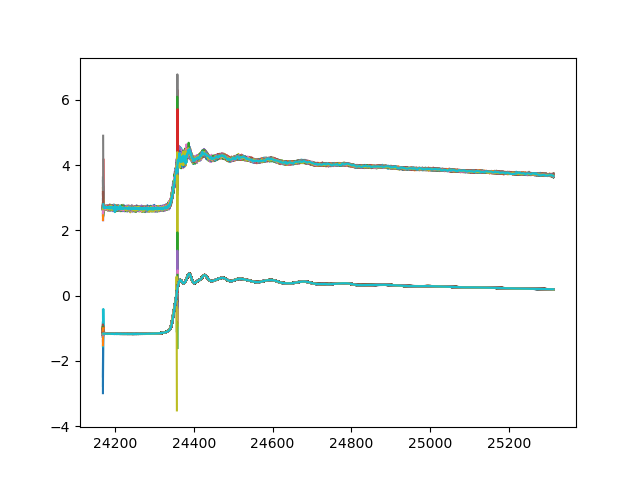

In [73]:
# E,mu=data_collect_ref(filenames)
# plt.figure()
# for i in range(len(E)):
#     plt.plot(E[i],mu[i])

array([24169.5       , 24171.79262066, 24174.08524132, 24176.37786198,
       24178.67048264, 24180.9631033 , 24183.25572395, 24185.54834461,
       24187.84096527, 24190.13358593, 24192.42620659, 24194.71882725,
       24197.01144791, 24199.30406857, 24201.59668923, 24203.88930989,
       24206.18193055, 24208.4745512 , 24210.76717186, 24213.05979252,
       24215.35241318, 24217.64503384, 24219.9376545 , 24222.23027516,
       24224.52289582, 24226.81551648, 24229.10813714, 24231.4007578 ,
       24233.69337846, 24235.98599911, 24238.27861977, 24240.57124043,
       24242.86386109, 24245.15648175, 24247.44910241, 24249.74172307,
       24252.03434373, 24254.32696439, 24256.61958505, 24258.91220571,
       24261.20482636, 24263.49744702, 24265.79006768, 24268.08268834,
       24270.375309  , 24272.66792966, 24274.96055032, 24277.25317098,
       24279.54579164, 24281.8384123 , 24284.13103296, 24286.42365361,
       24288.71627427, 24291.00889493, 24293.30151559, 24295.59413625,
      

In [75]:
group_ave1=Group(energy=E_CH4,mu=mu_CH4,label=f"CH4_traj_{traj_num}")
group_ave2=Group(energy=E_O2,mu=mu_O2,label=f'O2_traj_{traj_num}')
# group_ave3=Group(energy=E_CH4,mu=mu_CH4,label=f'CH4_cyc_{cycle_num}')

In [90]:
# data_dict[key[key_num]]

E0=24348.324411410613


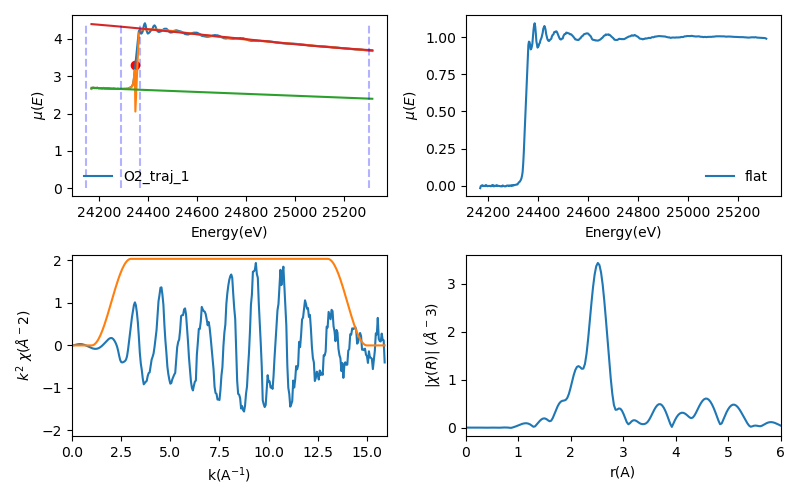

In [79]:
da.data_processing(group_ave1,e0=None, pre_start=-200,pre_end=-60,post_start=20,post_end=950,kweight=2,rbkg=1,
                  plot=False,kwin='hanning',dk=2,krange=[2,14])
da.data_processing(group_ave2,e0=None, pre_start=-200,pre_end=-60,post_start=20,post_end=950,kweight=2,rbkg=1,
                  plot=True,kwin='hanning',dk=2,krange=[2,14])
# da.data_processing(group_ave3,e0=None, pre_start=-200,pre_end=-60,post_start=20,post_end=950,kweight=2,rbkg=1,
#                   plot=True,kwin='hanning',dk=2,krange=[2,8])

In [88]:
filenames=sorted(glob("/nsls2/data/qas-new/legacy/processed/2024/2/315439/Oscillatory_processed/ME*.dat"), key=os.path.getmtime,reverse=True)
data_dict=data_dict_modu(filenames)
key=list(data_dict.keys())
print("show key_num and corresponding measurement:")
for i in range(len(key)):
    print(f"{i}\t{key[i]}")

show key_num and corresponding measurement:
0	ME10_1st_dn_ME10_15sCH4_15sO2_60cycles_at_400C
1	ME10_1st_up_ME10_15sCH4_15sO2_60cycles_at_400C
2	ME05_1st_dn_ME05_Pd20_S1_at_200C_30sO2_30sCH4_60cycles
3	ME05_1st_up_ME05_Pd20_S1_at_200C_30sO2_30sCH4_60cycles
4	ME06_1st_dn_ME06_Pd20_S1_at_200C_5sO2_5sCH4_60cycles
5	ME06_1st_up_ME06_Pd20_S1_at_200C_5sO2_5sCH4_60cycles


num of trajactories:[5, 4, 3, 2, 1]
first=[2, 4, 12, 14, 22, 24]
first=[2, 4, 12, 14, 22, 24]
first=[2, 4, 12, 14, 22, 24]
first=[2, 4, 12, 14, 22, 24]
first=[2, 4, 12, 14, 22, 24]
num of trajactories:[5, 4, 3, 2, 1]
second=[6, 8, 10, 16, 18, 20]
second=[6, 8, 10, 16, 18, 20]
second=[6, 8, 10, 16, 18, 20]
second=[6, 8, 10, 16, 18, 20]
second=[6, 8, 10, 16, 18, 20]
500 500
E0=24348.324411410613
num of trajactories:[5, 4, 3, 2, 1]
first=[2, 4, 12, 14, 22, 24]
first=[2, 4, 12, 14, 22, 24]
first=[2, 4, 12, 14, 22, 24]
first=[2, 4, 12, 14, 22, 24]
first=[2, 4, 12, 14, 22, 24]
num of trajactories:[5, 4, 3, 2, 1]
second=[6, 8, 10, 16, 18, 20]
second=[6, 8, 10, 16, 18, 20]
second=[6, 8, 10, 16, 18, 20]
second=[6, 8, 10, 16, 18, 20]
second=[6, 8, 10, 16, 18, 20]


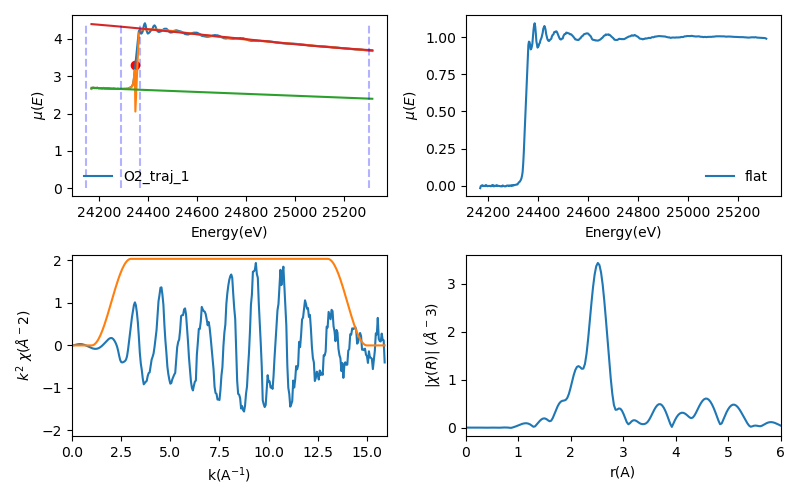

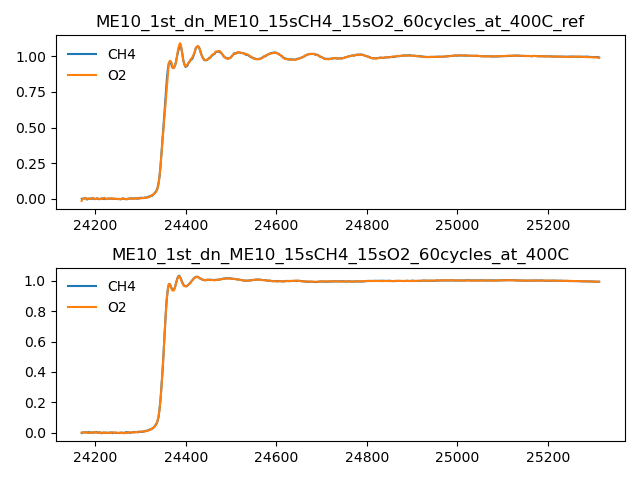

In [87]:
key_num=0
traj_num=1
total_scan=100
scans_per_switch=20

E_CH4,mu_CH4=get_ave_cycle(data_dict,key_num,mode='first',data_tag='ref',traj_num=traj_num,total_scan=total_scan,scans_per_switch=scans_per_switch)
E_O2,mu_O2=get_ave_cycle(data_dict,key_num,mode='second',data_tag='ref',traj_num=traj_num,total_scan=total_scan,scans_per_switch=scans_per_switch)
# E_CH4,mu_CH4=get_ave_cycle3(dic,key_num,mode='first',cycle_num=cycle_num,total_scan=total_scan)
print(len(E_O2),len(mu_O2))
bad_index=np.where((E_O2>24350)&(E_O2<24360))[0]
E_O2=np.delete(E_O2,bad_index)
mu_O2=np.delete(mu_O2,bad_index)
group_ave1=Group(energy=E_CH4,mu=mu_CH4,label=f"CH4_traj_{traj_num}")
group_ave2=Group(energy=E_O2,mu=mu_O2,label=f'O2_traj_{traj_num}')
da.data_processing(group_ave1,e0=None, pre_start=-200,pre_end=-60,post_start=20,post_end=950,kweight=2,rbkg=1,
                  plot=False,kwin='hanning',dk=2,krange=[2,14])
da.data_processing(group_ave2,e0=None, pre_start=-200,pre_end=-60,post_start=20,post_end=950,kweight=2,rbkg=1,
                  plot=True,kwin='hanning',dk=2,krange=[2,14])
fig,ax=plt.subplots(2,1)
ax[0].plot(group_ave1.energy,group_ave1.flat,label='CH4')
ax[0].plot(group_ave2.energy,group_ave2.flat,label='O2')
# plt.plot(group_ave2.energy,group_ave3.flat,label='CH4')
ax[0].legend(frameon=False)
ax[0].set_title(f"{key[key_num]}_ref")


E_CH4,mu_CH4=get_ave_cycle(data_dict,key_num,mode='first',data_tag='iff',traj_num=traj_num,total_scan=total_scan,scans_per_switch=scans_per_switch)
E_O2,mu_O2=get_ave_cycle(data_dict,key_num,mode='second',data_tag='iff',traj_num=traj_num,total_scan=total_scan,scans_per_switch=scans_per_switch)
group_ave1=Group(energy=E_CH4,mu=mu_CH4,label=f"CH4_traj_{traj_num}")
group_ave2=Group(energy=E_O2,mu=mu_O2,label=f'O2_traj_{traj_num}')
da.data_processing(group_ave1,e0=None, pre_start=-200,pre_end=-60,post_start=20,post_end=950,kweight=2,rbkg=1,
                  plot=False,kwin='hanning',dk=2,krange=[2,14])
da.data_processing(group_ave2,e0=None, pre_start=-200,pre_end=-60,post_start=20,post_end=950,kweight=2,rbkg=1,
                  plot=False,kwin='hanning',dk=2,krange=[2,14])

ax[1].plot(group_ave1.energy,group_ave1.flat,label='CH4')
ax[1].plot(group_ave2.energy,group_ave2.flat,label='O2')
# plt.plot(group_ave2.energy,group_ave3.flat,label='CH4')
ax[1].legend(frameon=False)
ax[1].set_title(key[key_num])
plt.tight_layout()
# plt.plot(group_ave1.energy,group_ave2.flat-group_ave1.flat,label='CH4-O2')
# # plt.plot(group_ave2.energy,group_ave2.flat,label='CH4')
# # plt.plot(group_ave2.energy,group_ave3.flat,label='CH4')
# plt.legend(frameon=False)
# plt.title(key[key_num])

num of trajactories:[5, 4, 3, 2, 1]
first=[2, 4, 12, 14, 22, 24]
first=[2, 4, 12, 14, 22, 24]
first=[2, 4, 12, 14, 22, 24]
first=[2, 4, 12, 14, 22, 24]
first=[2, 4, 12, 14, 22, 24]
num of trajactories:[5, 4, 3, 2, 1]
second=[6, 8, 10, 16, 18, 20]
second=[6, 8, 10, 16, 18, 20]
second=[6, 8, 10, 16, 18, 20]
second=[6, 8, 10, 16, 18, 20]
second=[6, 8, 10, 16, 18, 20]


Text(0.5, 1.0, 'ME10_1st_dn_ME10_15sCH4_15sO2_60cycles_at_400C')

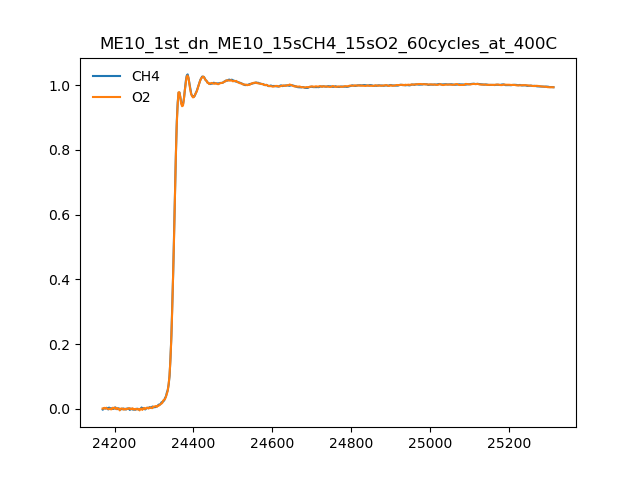

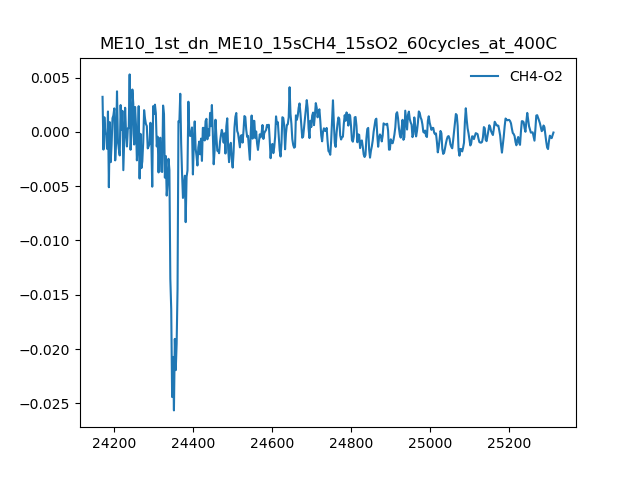

In [44]:
E_CH4,mu_CH4=get_ave_cycle(data_dict,key_num,mode='first',data_tag='iff',traj_num=traj_num,total_scan=total_scan,scans_per_switch=scans_per_switch)
E_O2,mu_O2=get_ave_cycle(data_dict,key_num,mode='second',data_tag='iff',traj_num=traj_num,total_scan=total_scan,scans_per_switch=scans_per_switch)
group_ave1=Group(energy=E_CH4,mu=mu_CH4,label=f"CH4_traj_{traj_num}")
group_ave2=Group(energy=E_O2,mu=mu_O2,label=f'O2_traj_{traj_num}')
da.data_processing(group_ave1,e0=None, pre_start=-200,pre_end=-60,post_start=20,post_end=950,kweight=2,rbkg=1,
                  plot=False,kwin='hanning',dk=2,krange=[2,14])
da.data_processing(group_ave2,e0=None, pre_start=-200,pre_end=-60,post_start=20,post_end=950,kweight=2,rbkg=1,
                  plot=False,kwin='hanning',dk=2,krange=[2,14])
plt.figure()
plt.plot(group_ave1.energy,group_ave1.flat,label='CH4')
plt.plot(group_ave2.energy,group_ave2.flat,label='O2')
# plt.plot(group_ave2.energy,group_ave3.flat,label='CH4')
plt.legend(frameon=False)
plt.title(key[key_num])
plt.figure()
plt.plot(group_ave1.energy,group_ave2.flat-group_ave1.flat,label='CH4-O2')
# plt.plot(group_ave2.energy,group_ave2.flat,label='CH4')
# plt.plot(group_ave2.energy,group_ave3.flat,label='CH4')
plt.legend(frameon=False)
plt.title(key[key_num])


Text(0.5, 1.0, 'ME10_1st_dn_ME10_15sCH4_15sO2_60cycles_at_400C')

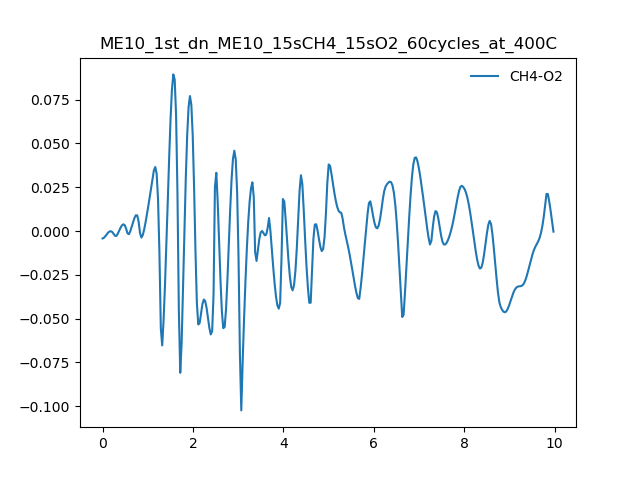

In [51]:

plt.figure()
plt.plot(group_ave1.r,group_ave2.chir_mag-group_ave1.chir_mag,label='CH4-O2')
# plt.plot(group_ave2.energy,group_ave2.flat,label='CH4')
# plt.plot(group_ave2.energy,group_ave3.flat,label='CH4')
plt.legend(frameon=False)
plt.title(key[key_num])

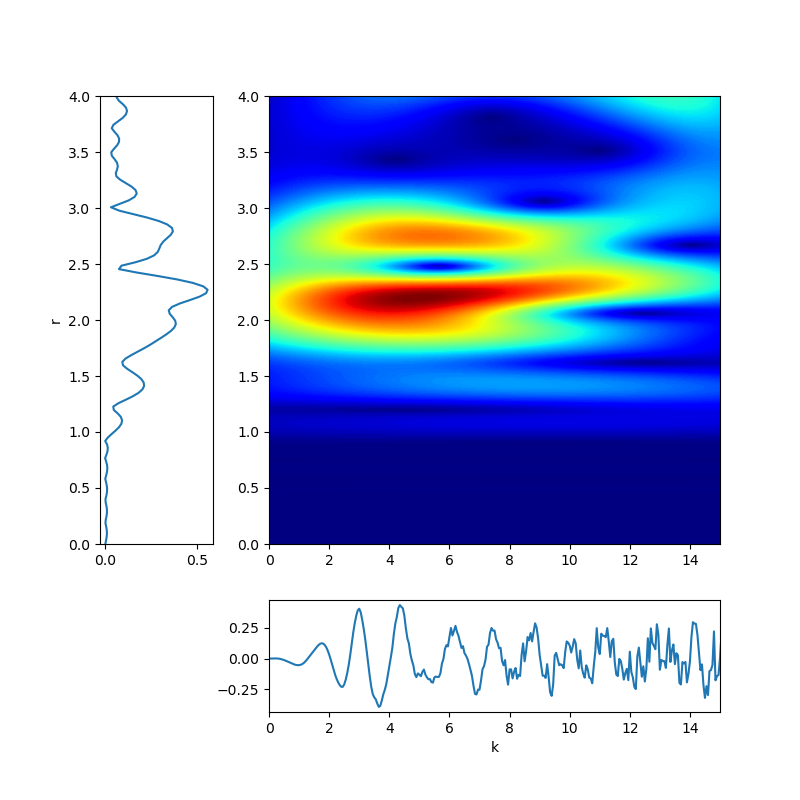

In [52]:
da.wavelet_transform(group_ave1, kweight=2,  plot_spec={'rrange':[0,4],'krange':[0,15]})

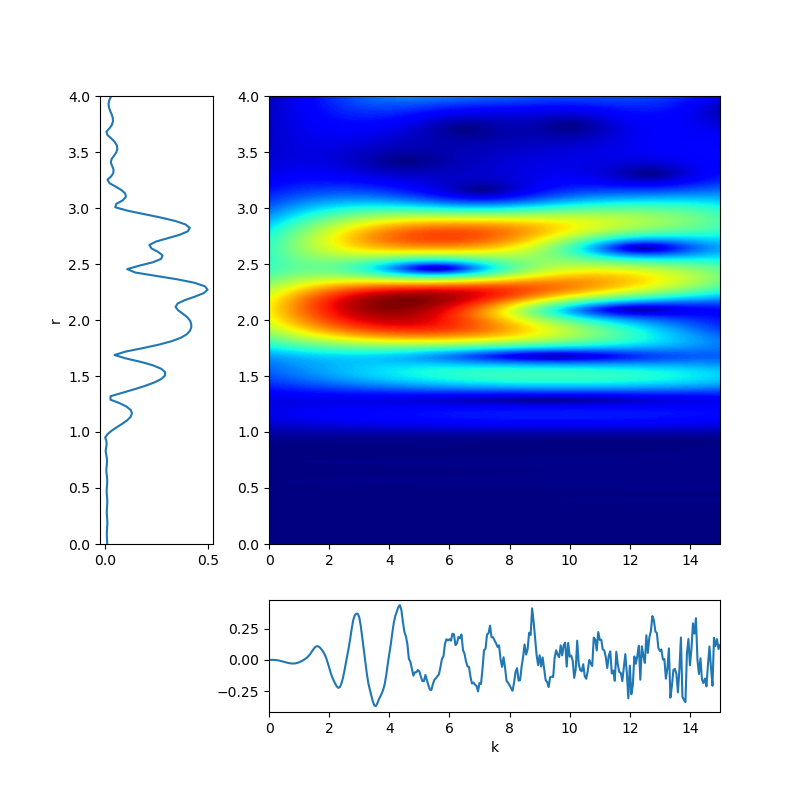

In [53]:
da.wavelet_transform(group_ave2, kweight=2,plot_spec={'rrange':[0,4],'krange':[0,15]})

In [31]:
filenames=sorted(glob("/nsls2/data/qas-new/legacy/processed/2024/1/313272/Oscillatory_processed/*.dat"), key=os.path.getmtime,reverse=True)
dic=data_dict_modu(filenames)
key=list(dic.keys())
for i in range(len(key)):
    print(f"{i}\t{key[i]}")

IndexError: list index out of range